# **Movie Recommeded System**

**Sumber Dataset**: [Movie Lens Small Latest Dataset](https://www.kaggle.com/datasets/shubhammehta21/movie-lens-small-latest-dataset/)

**Deskripsi**: Notebook ini berisi proses pembuatan sistem rekomendasi film

## **Import Library yang Dibutuhkan**

In [ ]:
! pip install kaggle

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **Data Understanding**

Pada bagian ini, data akan dieksplor dengan tujuan untuk memahami isi, kualitas, dan penanganan data pada bagian selanjuetnya.

Dataset yang digunakan dalam proyek kali ini berjudul [Movie Lens Small Latest Dataset](https://www.kaggle.com/datasets/shubhammehta21/movie-lens-small-latest-dataset/). Dataset ini berisi data rating dan free tagging (label bebas yang diberikan user kepada film) dari website [movielens.org](https://movielens.org/), sebuah layanan rekomendasi film. Untuk lebih detilnya, dataset ini berisi 100836 rating dan 3683 data tag di 9742 film. Data ini dibuat oleh 610 pengguna antara 29 Maret 1996 dan 24 September 2018.

Setelah dataset diunduh dan diekstrak, akan didapatkan file sebagai berikut.
- README.txt
- links.csv
- movies.csv
- ratings.csv
- tags.csv

Pada proyek kali ini, file yang akan digunakan meliputi movies.csv dan ratings.csv.

### **Data Loading**

Pada bagian ini, file **movies.csv** dan **ratings.csv** akan dimuat menggunakan library pandas

In [ ]:
# Mengatur config kaggle supaya bisa download langsung lewat CLI
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive/Kaggle'

In [ ]:
# Download dataset dari kaggle
! kaggle datasets download shubhammehta21/movie-lens-small-latest-dataset

Dataset URL: https://www.kaggle.com/datasets/shubhammehta21/movie-lens-small-latest-dataset
License(s): unknown
  0% 0.00/971k [00:00<?, ?B/s]
100% 971k/971k [00:00<00:00, 884MB/s]


In [ ]:
# Unzip dataset
! unzip /content/movie-lens-small-latest-dataset.zip

Archive:  /content/movie-lens-small-latest-dataset.zip
  inflating: README.txt              
  inflating: links.csv               
  inflating: movies.csv              
  inflating: ratings.csv             
  inflating: tags.csv                


#### Membaca file movies.csv

In [ ]:
movies_df = pd.read_csv('/content/movies.csv')
movies_df

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


#### Membaca file ratings.csv

In [ ]:
ratings_df = pd.read_csv('/content/ratings.csv')
ratings_df

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


**Insight:** Dari pembacaan data di atas, diketahui bahwa jumlah data dalam movies_df adalah 9742 data dengan 3 fitur utama yaitu movieId, title, dan genres. Sedangkan data dalam rating_df berjumlah 100836 data dengan 4 fitur utama, meliputi userId, movieId, rating, dan timestamp



### **Exploratory Data Analysis**

Exploratory Data Analysis merupakan proses investigasi awal pada data untuk menganalisis karakteristik, menemukan pola, anomali, dan memeriksa asumsi pada data. Teknik ini biasanya menggunakan bantuan statistik dan representasi grafis atau visualisasi. Tujuan dari EDA adalah untuk memperoleh wawasan awal yang mendalam mengenai data dan menentukan langkah selanjutnya dalam analisis atau pemodelan.

Pada proyek kali ini, proses yang akan kita lakukan meliputi:
- **Deskripsi Data**
- **Univariate Analysis**  
- **Multivariate Analaysis**  


#### **Deskripsi Data**

In [ ]:
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


movies_df di atas berisi 9742 data film dengan 3 fitur utama, meliputi:
1. movieId (integer) -  Unique ID untuk film, contoh 1, 2, 3, dsb.
2. title (object) - judul film, contoh Toy Story
3. genre (object) - genre film, jika lebih dari satu dipisah dengan '|'. Contohnya Comedy|Romance

In [ ]:
movies_df.describe(include='all')

,movieId,title,genres
count,9742.000000,9742,9742
unique,NaN,9737,951
top,NaN,Emma (1996),Drama
freq,NaN,2,1053
mean,42200.353623,NaN,NaN
std,52160.494854,NaN,NaN
min,1.000000,NaN,NaN
25%,3248.250000,NaN,NaN
50%,7300.000000,NaN,NaN
75%,76232.000000,NaN,NaN


In [ ]:
ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


rating_df di atas berisi 100836 data rating dengan 4 fitur utama, meliputi:
1. userId (integer) -  Unique ID untuk user, contoh 1, 2, 3, dsb.
2. movieId (integer) - Unique ID untuk film, contoh 1, 2, 3, dsb.
3. rating (float) - nilai/rating film yang diberikan oleh user, dari skala 0.5 - 5.0
4. timestamp (integer) - Waktu rating direkam (format Unix timestamp)

In [ ]:
ratings_df.describe(include='all')

,userId,movieId,rating,timestamp
count,100836.000000,100836.000000,100836.000000,1.008360e+05
mean,326.127564,19435.295718,3.501557,1.205946e+09
std,182.618491,35530.987199,1.042529,2.162610e+08
min,1.000000,1.000000,0.500000,8.281246e+08
25%,177.000000,1199.000000,3.000000,1.019124e+09
50%,325.000000,2991.000000,3.500000,1.186087e+09
75%,477.000000,8122.000000,4.000000,1.435994e+09
max,610.000000,193609.000000,5.000000,1.537799e+09


**Insight**: Dataset yang digunakan dalam proyek ini memiliki dua tipe data utama, yaitu numerikal dan kategorikal. Numerikal meliputi `userId`, `movieId`, `rating`, dan `timestamp`. Kemudian untuk kategorikal meliputi `title` dan `genre`. Fitur rating dalam data di atas memiliki nilai rata-rata sebesar 3.55 dari skala 0.5 hingga 5. Nilai ini menyisyaratkan bahwa rating yang diberikan pengguna rata-rata adalah sedang/lumayan atau bisa juga karena keberagaman rating yang ada dalam data proyek ini.

#### **Univariate Analysis**

Analisis ini merupakan analisis pada tiap fitur dengan tujuan untuk mengetahui karakteristik dan struktur pada variabel

In [ ]:
print('Jumlah data film dalam movie_df: ', len(movies_df.movieId.unique()))
print('Jumlah data genre film: ', len(movies_df.genres.unique()))
print('Jumlah data film yang diberi rating dalam rating_df: ', len(ratings_df.movieId.unique()))
print('Jumlah data user yang memberi rating : ', len(ratings_df.userId.unique()))
print('Jumlah data rating yang diberikan: ', len(ratings_df))

Jumlah data film dalam movie_df:  9742
Jumlah data genre film:  951
Jumlah data film yang diberi rating dalam rating_df:  9724
Jumlah data user yang memberi rating :  610
Jumlah data rating yang diberikan:  100836


Terlihat pada output di atas bahwa jumlah film unik pada movies_df dan ratings_df berbeda. Dapat disimpulkan bahwa tidak semua film dalam movies_df sudah diberi rating oleh pengguna

In [ ]:
print('Genre film: ', movies_df.genres.unique())

Genre film:  ['Adventure|Animation|Children|Comedy|Fantasy'
 'Adventure|Children|Fantasy' 'Comedy|Romance' 'Comedy|Drama|Romance'
 'Comedy' 'Action|Crime|Thriller' 'Adventure|Children' 'Action'
 'Action|Adventure|Thriller' 'Comedy|Horror'
 'Adventure|Animation|Children' 'Drama' 'Action|Adventure|Romance'
 'Crime|Drama' 'Drama|Romance' 'Action|Comedy|Crime|Drama|Thriller'
 'Comedy|Crime|Thriller' 'Crime|Drama|Horror|Mystery|Thriller'
 'Drama|Sci-Fi' 'Children|Drama' 'Adventure|Drama|Fantasy|Mystery|Sci-Fi'
 'Mystery|Sci-Fi|Thriller' 'Children|Comedy' 'Drama|War'
 'Action|Crime|Drama' 'Action|Adventure|Fantasy' 'Comedy|Drama|Thriller'
 'Mystery|Thriller' 'Animation|Children|Drama|Musical|Romance'
 'Crime|Mystery|Thriller' 'Adventure|Drama' 'Drama|Thriller'
 'Comedy|Crime' 'Action|Sci-Fi|Thriller' 'Action|Comedy|Horror|Thriller'
 'Comedy|Drama' 'Documentary' 'Action|Crime|Drama|Thriller'
 'Crime|Drama|Romance' 'Action|Adventure|Drama' 'Action|Thriller'
 'Drama|Horror|Thriller' 'Comedy|Hor

Terlihat dari output di atas, data genre kebanyakan berisi lebih dari satu tiap datanya. Hal ini normal untuk sebuah film

In [ ]:
# Melihat genre secara unique atau satuan
def genre_unique():
  genre = []
  for i in movies_df.genres.unique():
    for j in i.split('|'):
      if j not in genre:
        genre.append(j)
  return genre

print('Jumlah genre unik: ', len(genre_unique()))
print('Genre unik: ')
print(*genre_unique(), sep='\n')

Jumlah genre unik:  20
Genre unik: 
Adventure
Animation
Children
Comedy
Fantasy
Romance
Drama
Action
Crime
Thriller
Horror
Mystery
Sci-Fi
War
Musical
Documentary
IMAX
Western
Film-Noir
(no genres listed)


Dari output di atas, terlihat bahwa ada film yang genrenya tidak dicantumkan atau tidak ditulis dalam data, representasi genrenya ditulis dengan no genre list

In [ ]:
movies_df[movies_df.genres == '(no genres listed)']

,movieId,title,genres
8517,114335,La cravate (1957),(no genres listed)
8684,122888,Ben-hur (2016),(no genres listed)
8687,122896,Pirates of the Caribbean: Dead Men Tell No Tal...,(no genres listed)
8782,129250,Superfast! (2015),(no genres listed)
8836,132084,Let It Be Me (1995),(no genres listed)
8902,134861,Trevor Noah: African American (2013),(no genres listed)
9033,141131,Guardians (2016),(no genres listed)
9053,141866,Green Room (2015),(no genres listed)
9070,142456,The Brand New Testament (2015),(no genres listed)
9091,143410,Hyena Road,(no genres listed)


In [ ]:
len(movies_df[movies_df.genres == '(no genres listed)'])

34

Terlihat bahwa ada 34 film yang tidak mencantumkan genrenya dalam data. Dan direpresentasikan dengan no genre list

**Cek Nilai Kosong**

In [ ]:
movies_df.isnull().sum()

,0
movieId,0
title,0
genres,0


In [ ]:
ratings_df.isnull().sum()

,0
userId,0
movieId,0
rating,0
timestamp,0


**Cek Nilai Duplikat**

In [ ]:
movies_df.duplicated().sum()

np.int64(0)

In [ ]:
ratings_df.duplicated().sum()

np.int64(0)

**Distribusi Data**

userId
414    2698
599    2478
474    2108
448    1864
274    1346
610    1302
68     1260
380    1218
606    1115
288    1055
Name: count, dtype: int64


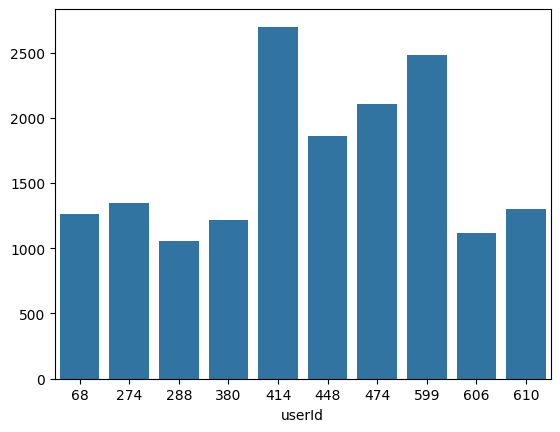

In [ ]:
# 10 userId pemberi rating paling banyak
print(ratings_df.userId.value_counts().sort_values(ascending=False).head(10))
sns.barplot(x=ratings_df.userId.value_counts().sort_values(ascending=False).head(10).index, y=ratings_df.userId.value_counts().sort_values(ascending=False).head(10).values)
plt.show()

rating
4.0    26818
3.0    20047
5.0    13211
3.5    13136
4.5     8551
2.0     7551
2.5     5550
1.0     2811
1.5     1791
0.5     1370
Name: count, dtype: int64


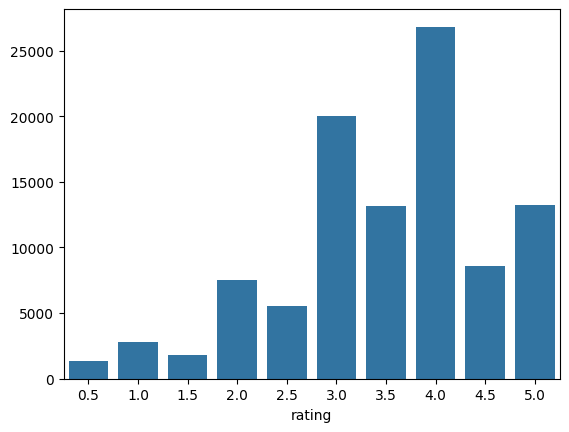

In [ ]:
rating_count = ratings_df.rating.value_counts().sort_values(ascending=False)
print(rating_count)

sns.barplot(x=rating_count.index, y=rating_count.values)
plt.show()

**Insight**:
- Dataset proyek ini memiliki 9742 data film unik. Dengan 20 kategori genre unik, meliputi Action hingga Western. Selain itu, terdapat pula genre '(no genres listed)' yang menunjukkan ada beberapa film yang data genrenya kurang lengkap
- Terdapat 34 data Genre bernilai '(no genres listed)' dalam dataset. Untuk proyek ini, kita akan menggantinya menjadi satu kata untuk mengurangi term saat proses TFIDF nantinya
- Dataset pada proyek ini memiliki 610 data pengguna unik, serta 100836 data rating yang diberikan pada film
- Jumlah data film unik pada movies_df dan ratings_df berbeda. Dapat disimpulkan bahwa tidak semua film dalam movies_df sudah diberi rating oleh pengguna
- Tidak ditemukan adanya nilai kosong dan duplikat pada data, sehingga penanganan tidak diperlukan
- Melalui eksplorasi, ditemukan bahwa pengguna dengan userId 414 merupakan pengguna yang paling banyak memberikan rating pada film (2698 rating), disusur dengan userId 599(2478 rating), serta userId 474 (2108 rating)
- Rating yang diberikan pengguna dalam dataset cukup beragam dari 0.5 hingga 5.0. Rating 4.0 merupakan rating terbanyak yang diberikan pengguna pada film, sedangkan 0.5 adalah rating dengan jumlah paling sedikit yang diberikan pengguna pada film

#### **Multivariate Analysis**

Multivariate analysis adalah jenis analisis statistik atau eksplorasi data yang melibatkan tiga atau lebih variabel secara bersamaan, dengan tujuan untuk Mencari pola, hubungan, atau pengaruh antar variabel

In [ ]:
# Top 10 film dengan rating terbaik
df = pd.merge(ratings_df, movies_df, on='movieId', how='left')
best_movies = df.groupby(by='title').agg({
    'rating': 'mean',
    'userId': 'count'
}).sort_values(by=['rating', 'userId'], ascending=False).head(10)
best_movies

,rating,userId
title,,
Belle époque (1992),5.0,2
Come and See (Idi i smotri) (1985),5.0,2
Enter the Void (2009),5.0,2
Heidi Fleiss: Hollywood Madam (1995),5.0,2
Jonah Who Will Be 25 in the Year 2000 (Jonas qui aura 25 ans en l'an 2000) (1976),5.0,2
Lamerica (1994),5.0,2
Lesson Faust (1994),5.0,2
'Salem's Lot (2004),5.0,1
12 Angry Men (1997),5.0,1


In [ ]:
# Top 10 paling banyak diberi rating
df = pd.merge(ratings_df, movies_df, on='movieId', how='left')
popular_movies = df.groupby(by='title').agg({
    'rating': 'mean',
    'userId': 'count'
}).sort_values(by=['userId'], ascending=False).head(10)
popular_movies

,rating,userId
title,,
Forrest Gump (1994),4.164134,329
"Shawshank Redemption, The (1994)",4.429022,317
Pulp Fiction (1994),4.197068,307
"Silence of the Lambs, The (1991)",4.161290,279
"Matrix, The (1999)",4.192446,278
Star Wars: Episode IV - A New Hope (1977),4.231076,251
Jurassic Park (1993),3.750000,238
Braveheart (1995),4.031646,237
Terminator 2: Judgment Day (1991),3.970982,224


**Insight**:
- Melaui eksplorasi, ditemukan bahwa Belle époque (1992), Come and See (Idi i smotri) (1985), Enter the Void (2009), Heidi Fleiss: Hollywood Madam (1995), Jonah Who Will Be 25 in the Year 2000 (Jonas qui aura 25 ans en l'an 2000) (1976), Lamerica (1994), dan Lesson Faust (1994) merupakan film dengan rating terbaik (5.0) jika diurutkan berdasarkan rating dan jumlah rating. Jumlah rating yang dimiliki oleh film tersebut adalah 2, yang mana sangat sedikit
- Melalui ekplorasi, ditemukan bahwa Forrest Gump (1994) merupakan film yang memiliki jumlah rating terbanyak yang diberikan pengguna (329 rating), disusul oleh Shawshank Redemption, The (1994) (317 rating), dan Pulp Fiction (1994) (307 rating)

### **Data Preparation**

Setelah melalui tahapan Data Understanding dan sebelum membangun model machine learning, diperlukan tahapan data preparation untuk memastikan bahwa data dalam kondisi bersih, konsisten, dan siap untuk digunakan dalam proses pelatihan model. Pada proyek ini akan dilakukan beberapa tahapan, yaitu,
- Menghapus Fitur yang tidak Diperlukan
- Tranformasi nilai fitur genres pada dataset
- Persiapan data model Content Based Filtering
- Persiapan data model Collaborative Filtering

Pada tahapan ini pembersihan data seperti menghapus nilai kosong dan duplikat tidak dilakukan karena tidak ditemukan adanya nilai-nilai tersebut pada data

#### **Menghapus Fitur yang tidak Diperlukan**

Pada proyek kali ini, kita tidak akan menggunakan fitur atau kolom timestamp. Oleh sebab itu, kita akan menghapusnya di sini

In [ ]:
ratings_df = ratings_df.drop(columns=['timestamp'])
ratings_df

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0
...,...,...,...
100831,610,166534,4.0
100832,610,168248,5.0
100833,610,168250,5.0
100834,610,168252,5.0


#### **Transformasi Fitur Genres**

Pada bagian ini, format nilai genre akan diubah dengan menghapus `'|'` menjadi `spasi`. Hal ini dilakukan agar nilai dari genres lebih rapi.

Pada bagian ini juga dilakukan pengubahan nilai '(no genres listed)' menjadi satu kata yaitu, '(no_genres_listed)'. Hal ini dilakukan untuk mengurangi matriks term yang dihasilkan oleh proses TFIDF nantinya

In [ ]:
movies_df.genres = movies_df.genres.str.replace('|', ' ')
movies_df.genres = movies_df.genres.str.replace('(no genres listed)', '(no_genres_listed)')
movies_df

,movieId,title,genres
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy
1,2,Jumanji (1995),Adventure Children Fantasy
2,3,Grumpier Old Men (1995),Comedy Romance
3,4,Waiting to Exhale (1995),Comedy Drama Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action Animation Comedy Fantasy
9738,193583,No Game No Life: Zero (2017),Animation Comedy Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action Animation


In [ ]:
print(len(movies_df[(movies_df.genres == '(no genres listed)')]))

0


In [ ]:
print(len(movies_df[(movies_df.genres == '(no_genres_listed)')]))

34


Terlihat pada output di atas bahwa nilai `'|'` sudah terganti menjadi spasi dan nilai '(no genres listed)' sudah berubah menjadi satu kata

#### **Persiapan data model Content Based Filtering**

##### **Mengubah genre film menjadi vektor TF-IDF**

Pada tahap ini, kita akan menggunakan fitur genres pada movies_df

In [ ]:
# Inisialisasi TfidfVectorizer
tf = TfidfVectorizer(token_pattern=r'(?u)\b[\w\-]+\b')

# Melakukan fit lalu ditransformasikan ke bentuk matrix
tfidf_matrix = tf.fit_transform(movies_df['genres'])

# Melihat ukuran matrix tfidf
print(tfidf_matrix.shape)

# Mapping array dari fitur index integer ke fitur nama
print(tf.get_feature_names_out())

(9742, 20)
['action' 'adventure' 'animation' 'children' 'comedy' 'crime'
 'documentary' 'drama' 'fantasy' 'film-noir' 'horror' 'imax' 'musical'
 'mystery' 'no_genres_listed' 'romance' 'sci-fi' 'thriller' 'war'
 'western']


In [ ]:
# Mengubah vektor tf-idf dalam bentuk matriks dengan fungsi todense()
tfidf_matrix.todense()

matrix([[0.        , 0.41684567, 0.51622547, ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.51236121, 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.57860574, 0.        , 0.81560738, ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]])

In [ ]:
# Membuat dataframe untuk melihat tf-idf matrix
pd.DataFrame(
    tfidf_matrix.todense(),
    columns=tf.get_feature_names_out(),
    index=movies_df.title
)

,action,adventure,animation,children,comedy,crime,documentary,drama,fantasy,film-noir,horror,imax,musical,mystery,no_genres_listed,romance,sci-fi,thriller,war,western
title,,,,,,,,,,,,,,,,,,,,
Toy Story (1995),0.000000,0.416846,0.516225,0.504845,0.267586,0.0,0.0,0.000000,0.482990,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
Jumanji (1995),0.000000,0.512361,0.000000,0.620525,0.000000,0.0,0.0,0.000000,0.593662,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
Grumpier Old Men (1995),0.000000,0.000000,0.000000,0.000000,0.570915,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.821009,0.0,0.0,0.0,0.0
Waiting to Exhale (1995),0.000000,0.000000,0.000000,0.000000,0.505015,0.0,0.0,0.466405,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.726241,0.0,0.0,0.0,0.0
Father of the Bride Part II (1995),0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Black Butler: Book of the Atlantic (2017),0.436010,0.000000,0.614603,0.000000,0.318581,0.0,0.0,0.000000,0.575034,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
No Game No Life: Zero (2017),0.000000,0.000000,0.682937,0.000000,0.354002,0.0,0.0,0.000000,0.638968,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
Flint (2017),0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


##### **Menghitung nilai similarity dengan cosine similarity**

In [ ]:
# Menghitung cosine similarity pada matrix tf-idf
cosine_sim = cosine_similarity(tfidf_matrix)
cosine_sim

array([[1.        , 0.81357774, 0.15276924, ..., 0.        , 0.4210373 ,
        0.26758648],
       [0.81357774, 1.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.15276924, 0.        , 1.        , ..., 0.        , 0.        ,
        0.57091541],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.4210373 , 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.26758648, 0.        , 0.57091541, ..., 0.        , 0.        ,
        1.        ]])

In [ ]:
# Membuat dataframe dari variabel cosine_sim dengan baris dan kolom berupa nama resto
cosine_sim_df = pd.DataFrame(cosine_sim, index=movies_df.title, columns=movies_df.title)
print('Shape:', cosine_sim_df.shape)

# Melihat similarity matrix pada setiap resto
cosine_sim_df.sample(5, axis=1).sample(10, axis=0)

Shape: (9742, 9742)


title,King of Hearts (1966),Bad Boys (1995),Short Circuit (1986),Blade (1998),My Scientology Movie (2016)
title,,,,,
Underworld (2003),0.000000,0.233515,0.000000,0.653472,0.0
Spider (2002),0.153589,0.138543,0.000000,0.000000,0.0
What Women Want (2000),0.222934,0.201096,0.291043,0.000000,0.0
Nausicaä of the Valley of the Wind (Kaze no tani no Naushika) (1984),0.091995,0.082983,0.401014,0.000000,0.0
"Captain Newman, M.D. (1963)",1.000000,0.254856,0.199063,0.000000,0.0
Breakfast at Tiffany's (1961),0.194876,0.175787,0.000000,0.000000,0.0
No Holds Barred (1989),0.000000,0.482068,0.000000,0.534828,0.0
"Boondock Saints II: All Saints Day, The (2009)",0.125348,0.935912,0.000000,0.543697,0.0
Matinee (1993),0.531538,0.479470,0.374503,0.000000,0.0


#### **Persiapan data model Collaborative Filtering**

##### **Penggabungan Data**

In [ ]:
rating_movies = pd.merge(ratings_df, movies_df, on='movieId', how='left')
rating_movies.head()

,userId,movieId,rating,title,genres
0,1,1,4.0,Toy Story (1995),Adventure Animation Children Comedy Fantasy
1,1,3,4.0,Grumpier Old Men (1995),Comedy Romance
2,1,6,4.0,Heat (1995),Action Crime Thriller
3,1,47,5.0,Seven (a.k.a. Se7en) (1995),Mystery Thriller
4,1,50,5.0,"Usual Suspects, The (1995)",Crime Mystery Thriller


##### **Encoding ID Pengguna dan Film**

In [ ]:
# Mengubah userId menjadi list tanpa nilai yang sama
user_ids = rating_movies['userId'].unique().tolist()
print('list userId: ', user_ids)

# Melakukan encoding userId
user_to_user_encoded = {x: i for i, x in enumerate(user_ids)}
print('encoded userId : ', user_to_user_encoded)

# Melakukan proses encoding angka ke ke userId
user_encoded_to_user = {i: x for i, x in enumerate(user_ids)}
print('encoded angka ke userId: ', user_encoded_to_user)

list userId:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219

In [ ]:
# Mengubah movieId menjadi list tanpa nilai yang sama
movie_ids = rating_movies['movieId'].unique().tolist()

# Melakukan proses encoding movieId
movie_to_movie_encoded = {x: i for i, x in enumerate(movie_ids)}

# Melakukan proses encoding angka ke movieId
movie_encoded_to_movie = {i: x for i, x in enumerate(movie_ids)}

In [ ]:
# Mapping userID ke dataframe user
rating_movies['user'] = rating_movies['userId'].map(user_to_user_encoded)

# Mapping placeID ke dataframe resto
rating_movies['movie'] = rating_movies['movieId'].map(movie_to_movie_encoded)

##### **Pengacakan Dataset**

In [ ]:
# Pengacakan dataset untuk menghindari Bias Urutan Data dan
rating_movies = rating_movies.sample(frac=1, random_state=42)
rating_movies

,userId,movieId,rating,title,genres,user,movie
67037,432,77866,4.5,Robin Hood (2010),Action Adventure Drama Romance War,431,4730
42175,288,474,3.0,In the Line of Fire (1993),Action Thriller,287,474
93850,599,4351,3.0,Point Break (1991),Action Crime Thriller,598,2631
6187,42,2987,4.0,Who Framed Roger Rabbit? (1988),Adventure Animation Children Comedy Crime Fant...,41,194
12229,75,1610,4.0,"Hunt for Red October, The (1990)",Action Adventure Thriller,74,727
...,...,...,...,...,...,...,...
6265,42,4005,4.0,"Living Daylights, The (1987)",Action Adventure Thriller,41,1873
54886,364,141,4.0,"Birdcage, The (1996)",Comedy,363,524
76820,480,6867,4.0,"Station Agent, The (2003)",Comedy Drama,479,2240
860,6,981,3.0,Dangerous Ground (1997),Drama,5,712


##### **Normalisasi Rating ke dalam rentang 0-1**

In [ ]:
# Mendapatkan jumlah user
num_users = len(user_to_user_encoded)
print(num_users)

# Mendapatkan jumlah film
num_movies = len(movie_encoded_to_movie)
print(num_movies)

# Nilai minimum rating
min_rating = min(rating_movies['rating'])

# Nilai maksimal rating
max_rating = max(rating_movies['rating'])

print('Number of User: {}, Number of movies: {}, Min Rating: {}, Max Rating: {}'.format(
    num_users, num_movies, min_rating, max_rating
))

In [ ]:
# Membuat variabel x untuk mencocokkan data user dan film menjadi satu value
x = rating_movies[['user', 'movie']].values

# Membuat variabel y untuk membuat rating dari hasil
y = rating_movies['rating'].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

[[ 431 4730]
 [ 287  474]
 [ 598 2631]
 ...
 [ 479 2240]
 [   5  712]
 [ 102 2046]] [0.88888889 0.55555556 0.55555556 ... 0.77777778 0.55555556 1.        ]


##### **Pembagian Data Pelatihan dan Validasi**

In [ ]:
# Membagi menjadi 80% data train dan 20% data validasi
train_indices = int(0.8 * rating_movies.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:]
)

print(x, y)

### Modelling

Setelah melakukan Data Preparation, selanjutnya adalah melakukan modelling machine learning. Modelling dalam sistem rekomendasi adalah proses membangun metode yang dapat memberikan rekomendasi berdasarkan preferensi dan kebutuhan pengguna. Dalam kasus ini, sistem rekomendasi yang dibuat menggunakan pendekatan Content-Based Filtering berbasis similarity dan Collaborative Filtering berbasis deep learning

#### **Content-based Filtering**

Pendekatan pertama yang digunakan adalah **Content-Based Filtering**, yaitu metode yang memberikan rekomendasi berdasarkan kesamaan konten antar item. Dalam hal ini, yang digunakan sebagai fitur konten adalah *genres* dari setiap film.

**Langkah-langkah**:
- Data pada kolom `genres` diubah menjadi representasi numerik menggunakan TF-IDF.
- Kemudian dihitung *cosine similarity* antar film berdasarkan TF-IDF tersebut.
- Untuk setiap film yang pernah disukai oleh pengguna, sistem akan merekomendasikan Top-N film lain yang memiliki tingkat kemiripan tertinggi.

In [ ]:
def movies_recommendations(judul_film, similarity_data=cosine_sim_df, items=movies_df[['title', 'genres']], k=10):
    """
    Rekomendasi Film berdasarkan kemiripan dataframe

    Parameter:
    ---
    judul_film : tipe data string (str)
                Judul Film (index kemiripan dataframe)
    similarity_data : tipe data pd.DataFrame (object)
                      Kesamaan dataframe, simetrik, dengan judul film sebagai
                      indeks dan kolom
    items : tipe data pd.DataFrame (object)
            Mengandung kedua nama dan fitur lainnya yang digunakan untuk mendefinisikan kemiripan
    k : tipe data integer (int)
        Banyaknya jumlah rekomendasi yang diberikan
    ---


    Pada index ini, kita mengambil k dengan nilai similarity terbesar
    pada index matrix yang diberikan (i).
    """

    if judul_film not in similarity_data.columns:
        raise ValueError(f"Judul film '{judul_film}' tidak ditemukan dalam data.")


    # Mengambil data dengan menggunakan argpartition untuk melakukan partisi secara tidak langsung sepanjang sumbu yang diberikan
    # Dataframe diubah menjadi numpy
    # Range(start, stop, step)
    index = similarity_data.loc[:,judul_film].to_numpy().argpartition(
        range(-1, -k, -1))
    # dengan menggunakan argpartition, kita mengambil sejumlah nilai k tertinggi dari similarity data (dalam kasus ini: dataframe cosine_sim_df)
    # Mengambil data dengan similarity terbesar dari index yang ada
    closest = similarity_data.columns[index[-1:-(k+2):-1]]

    # Drop judul_film agar judul film yang dicari tidak muncul dalam daftar rekomendasi
    closest = closest.drop(judul_film, errors='ignore')

    return pd.DataFrame(closest).merge(items).head(k)

#### **Collaborative Filtering**



Pendekatan kedua adalah **Collaborative Filtering berbasis Deep Learning**. Metode ini belajar dari interaksi antara pengguna dan item (film) dalam bentuk rating, tanpa melihat konten dari film tersebut. Model ini digunakan untuk memprediksi rating yang mungkin diberikan pengguna terhadap film yang belum pernah ditonton. Dari hasil tersebut diambil **Top-10 film rekomendasi** dengan prediksi rating tertinggi.


In [ ]:
class RecommenderNet(tf.keras.Model):

  # Insialisasi fungsi
  def __init__(self, num_users, num_movies, embedding_size, **kwargs):
    super(RecommenderNet, self).__init__(**kwargs)
    self.num_users = num_users
    self.num_movies = num_movies
    self.embedding_size = embedding_size
    self.user_embedding = layers.Embedding( # layer embedding user
        num_users,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.user_bias = layers.Embedding(num_users, 1) # layer embedding user bias
    self.resto_embedding = layers.Embedding( # layer embeddings resto
        num_movies,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.movies_bias = layers.Embedding(num_movies, 1) # layer embedding resto bias

  def call(self, inputs):
    user_vector = self.user_embedding(inputs[:,0]) # memanggil layer embedding 1
    user_bias = self.user_bias(inputs[:, 0]) # memanggil layer embedding 2
    movies_vector = self.resto_embedding(inputs[:, 1]) # memanggil layer embedding 3
    movies_bias = self.movies_bias(inputs[:, 1]) # memanggil layer embedding 4

    dot_user_movies = tf.tensordot(user_vector, movies_vector, 2)

    x = dot_user_movies + user_bias + movies_bias

    return tf.nn.sigmoid(x) # activation sigmoid

In [ ]:
model = RecommenderNet(num_users, num_movies, 50) # inisialisasi model

# model compile
model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(learning_rate=0.001),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

In [ ]:
# Memulai training

history = model.fit(
    x = x_train,
    y = y_train,
    batch_size = 32,
    epochs = 30,
    validation_data = (x_val, y_val)
)

Epoch 1/30
2521/2521 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - loss: 0.6545 - root_mean_squared_error: 0.2500 - val_loss: 0.6175 - val_root_mean_squared_error: 0.2117
Epoch 2/30
2521/2521 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.6132 - root_mean_squared_error: 0.2079 - val_loss: 0.6137 - val_root_mean_squared_error: 0.2072
Epoch 3/30
2521/2521 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.6074 - root_mean_squared_error: 0.2017 - val_loss: 0.6100 - val_root_mean_squared_error: 0.2032
Epoch 4/30
2521/2521 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 0.6046 - root_mean_squared_error: 0.1991 - val_loss: 0.6083 - val_root_mean_squared_error: 0.2013
Epoch 5/30
2521/2521 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.6028 - root_mean_squared_error: 0.1960 - val_loss: 0.6082 - val_root_mean_squared_error: 0.2010
Epoch 6/30
2521/2521 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 0.6020 - root_mean_squared_error: 0.1948 - val_loss: 0.6083 - val_root_mean_squared_error: 0.2009
Epoch 7/30
2521/2521 ━━━━━━━━━━━━━━━━

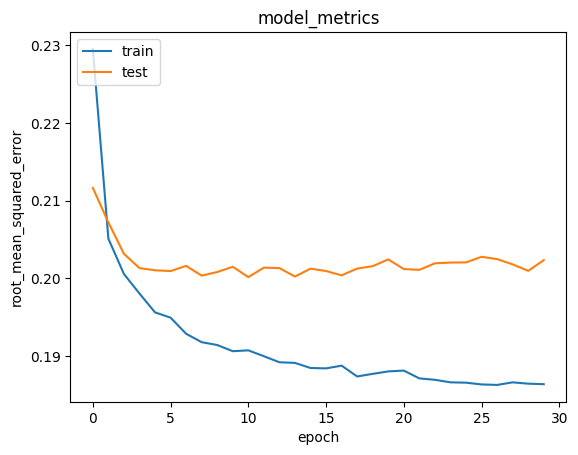

In [ ]:
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model_metrics')
plt.ylabel('root_mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


Dari gambar grafik pelatihan tersebut RMSE dapat diketahui beberapa poin sebagai berikut:
- RMSE data train menurun secara konsisten dari sekitar 0.23 ke sekitar 0.185, menunjukkan bahwa model berhasil belajar dengan baik pada data pelatihan.
- RMSE data test awalnya juga menurun tajam hingga sekitar epoch ke-3 atau ke-4, tetapi kemudian cenderung stagnan dan sedikit fluktuatif di kisaran 0.20.
- Gap antara RMSE train dan test mulai melebar setelah epoch ke-5, yang mengindikasikan adanya kemungkinan overfitting—model terlalu menyesuaikan diri dengan data pelatihan dan kurang generalisasi ke data test.
- Diketahui nilai `RMSE akhir` untuk data `train` sebesar `0.1866`, sedangkan `nilai RMSE` untuk data `validation` sebesar `0.2023`

### **Evaluation**

Pada bagian ini digunakan dua metrik evaluasi untuk menilai kinerja model sistem rekomendasi yang dibangun, yaitu **Root Mean Squared Error (RMSE)** dan **Precision@K**. Kedua metrik ini digunakan untuk mengukur performa model dari sisi regresi dan klasifikasi Top-N rekomendasi. RMSE untuk model Collaborative Filtering, sedangkan Precision@K untuk model Content-based Filtering

#### **Evaluasi Content-based Filtering**

In [ ]:
print("Rekomendasi untuk: ")
print(movies_df[movies_df.title == 'Jumanji (1995)'].title[1])
print("genre: ", movies_df[movies_df.title == 'Jumanji (1995)'].genres[1])

# Mendapatkan rekomendasi film yang mirip Jumanji (1995)
movies_recommendations('Jumanji (1995)')

Rekomendasi untuk: 
Jumanji (1995)
genre:  Adventure Children Fantasy


,title,genres
0,The Cave of the Golden Rose (1991),Adventure Children Fantasy
1,"NeverEnding Story II: The Next Chapter, The (1...",Adventure Children Fantasy
2,"NeverEnding Story, The (1984)",Adventure Children Fantasy
3,"NeverEnding Story III, The (1994)",Adventure Children Fantasy
4,Alice Through the Looking Glass (2016),Adventure Children Fantasy
5,Gulliver's Travels (1996),Adventure Children Fantasy
6,"Chronicles of Narnia: The Lion, the Witch and ...",Adventure Children Fantasy
7,Return to Oz (1985),Adventure Children Fantasy
8,Bridge to Terabithia (2007),Adventure Children Fantasy
9,"Chronicles of Narnia: Prince Caspian, The (2008)",Adventure Children Fantasy


Terlihat pada tabel di atas, bahwa Jumlah rekomendasi yang relevan adalah adalah 10. Oleh sebab itu, maka dapat disimpulkan `nilai precision@k untuk model ini adalah 10/10 atau 100%` (hasil dari jumlah rekomendasi yang relevan dibagi dengan total rekomendasi)

#### **Evaluation Collaborative Filtering**

In [ ]:
def recommend_movies(user_id):
  movies_watched_by_user = rating_movies[rating_movies.userId == user_id]
  # Operator bitwise (~), bisa diketahui di sini https://docs.python.org/3/reference/expressions.html
  movies_not_watched = movies_df[~movies_df['movieId'].isin(movies_watched_by_user.movieId.values)]['movieId']
  movies_not_watched = list(
      set(movies_not_watched)
      .intersection(set(movie_to_movie_encoded.keys()))
  )

  movies_not_watched = [[movie_to_movie_encoded.get(x)] for x in movies_not_watched]
  user_encoder = user_to_user_encoded.get(user_id)
  user_resto_array = np.hstack(
      ([[user_encoder]] * len(movies_not_watched), movies_not_watched)
  )
  ratings = model.predict(user_resto_array).flatten()

  top_ratings_indices = ratings.argsort()[-10:][::-1]
  recommended_movies_ids = [
      movie_encoded_to_movie.get(movies_not_watched[x][0]) for x in top_ratings_indices
  ]

  print('Showing recommendations for users: {}'.format(user_id))
  print('===' * 9)
  print('Movies with high ratings from user')
  print('----' * 8)

  top_movies_user = (
      movies_watched_by_user.sort_values(
          by = 'rating',
          ascending=False
      )
      .head(5)
      .movieId.values
  )

  movies_df_rows = movies_df[movies_df['movieId'].isin(top_movies_user)]
  for row in movies_df_rows.itertuples():
      print(row.title, ' genre: ', row.genres)

  print('----' * 8)
  print('Top 10 movies recommendation')
  print('----' * 8)

  recommended_movies = movies_df[movies_df['movieId'].isin(recommended_movies_ids)]
  for row in recommended_movies.itertuples():
      print(row.title, ' genre: ', row.genres)

# Mengambil sample user
user_id = rating_movies.userId.sample(1).iloc[0]
recommend_movies(user_id)

277/277 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Showing recommendations for users: 318
Movies with high ratings from user
--------------------------------
Monty Python's The Meaning of Life (1983)  genre:  Comedy
Woman Under the Influence, A (1974)  genre:  Drama
Summer's Tale, A (Conte d'été) (1996)  genre:  Comedy Drama Romance
Black Dynamite (2009)  genre:  Action Comedy
Nasu: Summer in Andalusia (2003)  genre:  Animation
--------------------------------
Top 10 movies recommendation
--------------------------------
Paths of Glory (1957)  genre:  Drama War
Jules and Jim (Jules et Jim) (1961)  genre:  Drama Romance
Trial, The (Procès, Le) (1962)  genre:  Drama
Adam's Rib (1949)  genre:  Comedy Romance
Bad Boy Bubby (1993)  genre:  Drama
Memories of Murder (Salinui chueok) (2003)  genre:  Crime Drama Mystery Thriller
Son of Rambow (2007)  genre:  Children Comedy Drama
Day of the Doctor, The (2013)  genre:  Adventure Drama Sci-Fi
Captain Fantastic (2016)  genre:  Drama
Band of Brothers (2001) 

Dari tabel hasil rekomendasi di atas, dapat disimpulkan bahwa hasil rekomendasi cukup presisi dalam merekomendasikan film untuk userId 318. Terlihat bahwa film yang direkomendasikan setidaknya memiliki satu genre yang mirip dengan film yang diberi rating user. Rata-rata film yang direkomendasikan rilis di bawah tahun 2010, kecuali film Captain Fantastic (2016).